In [1]:
%config Completer.use_jedi = False

import os
import pandas as pd
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem, rdFMCS, DataStructs, Draw
import umap
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler



In [2]:
bm = pd.read_csv('../data/BindingMOAD_selected_templates.csv', 
                 usecols=['UniProt_ID', 'Template', 'Smiles_String'])

new_pdb = pd.read_csv('../data/new_confirmed_pdb.csv')
new_pdb['Template'] = new_pdb.PDB_ID + '_' + new_pdb.Lig_Name
new_pdb = new_pdb.drop(columns=['PDB_ID', 'Lig_Name'])
new_pdb = new_pdb[['UniProt_ID', 'Template', 'Lig_Smiles']]
new_pdb = new_pdb.rename(columns={'Lig_Smiles': 'Smiles_String'})


enriched_bm = pd.read_csv('../data/selected_templates_updated_2024.csv', 
                          usecols=['UniProt_ID', 'Template', 'Smiles_String'])

In [3]:
bm['Mol'] =  bm['Smiles_String'].apply(Chem.MolFromSmiles)
new_pdb['Mol'] =  new_pdb['Smiles_String'].apply(Chem.MolFromSmiles)
enriched_bm['Mol'] =  enriched_bm['Smiles_String'].apply(Chem.MolFromSmiles)

bm = bm.dropna(subset='Mol').reset_index(drop=True)
new_pdb = new_pdb.dropna(subset='Mol').reset_index(drop=True)
enriched_bm = enriched_bm.dropna(subset='Mol').reset_index(drop=True)



[19:01:02] Explicit valence for atom # 31 N, 4, is greater than permitted
[19:01:02] Explicit valence for atom # 7 Cl, 5, is greater than permitted
[19:01:03] Explicit valence for atom # 35 O, 2, is greater than permitted
[19:01:03] Explicit valence for atom # 31 N, 4, is greater than permitted
[19:01:04] Explicit valence for atom # 18 S, 7, is greater than permitted
[19:01:05] Explicit valence for atom # 31 N, 4, is greater than permitted
[19:01:05] Explicit valence for atom # 7 Cl, 5, is greater than permitted
[19:01:06] Explicit valence for atom # 35 O, 2, is greater than permitted
[19:01:06] Explicit valence for atom # 31 N, 4, is greater than permitted
[19:01:07] Explicit valence for atom # 18 S, 7, is greater than permitted


In [4]:
df_all = bm.copy()
df_all['Source'] = 'BindingMOAD'

In [5]:
df_all = pd.concat([df_all, new_pdb], ignore_index=True)

In [6]:
df_all = df_all.drop_duplicates(subset=['Template'], keep='first')
df_all['Source'] = df_all['Source'].fillna('New2020')


In [7]:
fps = [AllChem.GetMorganGenerator(radius=2, fpSize=2048).GetFingerprint(m)
       for m in df_all["Mol"] if m is not None]
fps_array = np.array([np.array(fp) for fp in fps])


In [8]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(fps_array)

/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [9]:
df_all[['UMAP_1', 'UMAP_2']] = embedding


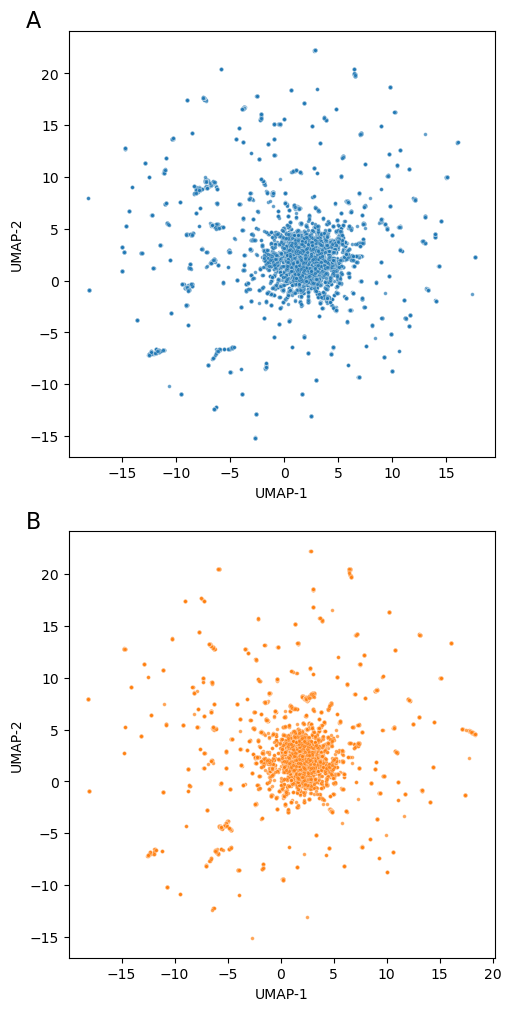

In [19]:
plot_labels = ['A', 'B']
               
fig, axes = plt.subplots(2, 1, figsize=(5, 10), constrained_layout=True)

# Panel A: DockBind
df_bm = df_all[df_all["Source"] == "BindingMOAD"]
sns.scatterplot(data=df_bm, x='UMAP_1', y='UMAP_2', alpha=0.7, s=7, ax=axes[0], color='#1f77b4')  # navy blue
axes[0].set_xlabel("UMAP-1")
axes[0].set_ylabel("UMAP-2")
axes[0].text(-0.1, 1.05, 'A', fontsize=16, ha='left', va='top', transform=axes[0].transAxes)

# Panel B: PDBbind
df_new = df_all[df_all["Source"] == "New2020"]
sns.scatterplot(data=df_new, x='UMAP_1', y='UMAP_2', alpha=0.7, s=7, ax=axes[1], color='#ff7f0e')  # dark orange
axes[1].set_xlabel("UMAP-1")
axes[1].set_ylabel("UMAP-2")
axes[1].text(-0.1, 1.05, 'B', fontsize=16, ha='left', va='top', transform=axes[1].transAxes)

plt.savefig('../images/chemical_space_bindingMOAD_new_pdb.png', 
            dpi=300,
            bbox_inches='tight')

plt.show()

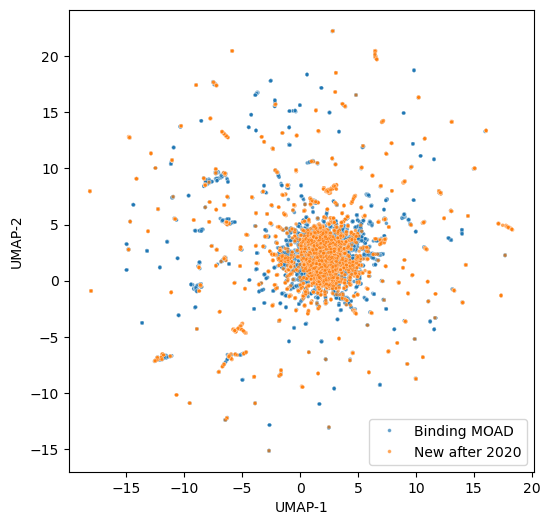

In [12]:
plt.figure(figsize=(6, 6))
ax = sns.scatterplot(  # <-- capture the axis here
    data=df_all,
    x='UMAP_1',
    y='UMAP_2',
    hue='Source',
    palette={'BindingMOAD': '#1f77b4', 'New2020': '#ff7f0e'},
    alpha=0.7,
    s=7
)

# Customize axes and title
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")

# Update legend labels
handles, labels = ax.get_legend_handles_labels()
custom_labels = {'BindingMOAD': 'Binding MOAD', 'New2020': 'New after 2020'}
new_labels = [custom_labels.get(label, label) for label in labels]
ax.legend(handles=handles, labels=new_labels, frameon=True, loc='lower right')

plt.savefig('../images/chemical_space_enriched_bm.png', 
            dpi=300,
            bbox_inches='tight')

plt.show()

/tmp/ipykernel_630911/2345906094.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_clusters))


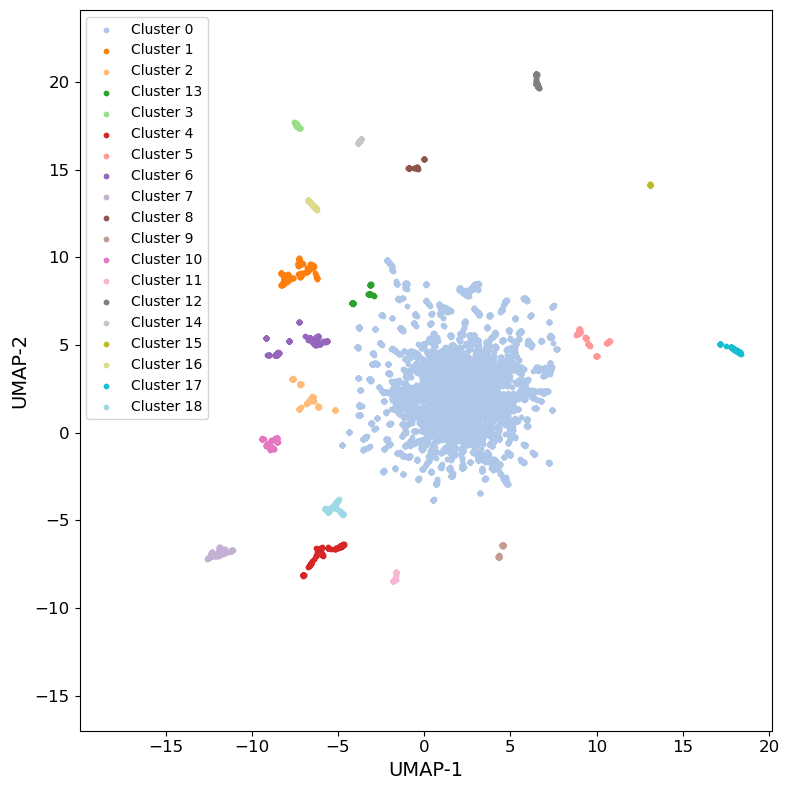

In [54]:
cluster_results = df_all.copy()


# Step 1: Standardize the UMAP coordinates
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_results[['UMAP_1', 'UMAP_2']])

# Step 2: Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.2, min_samples=50)
cluster_results['Cluster'] = dbscan.fit_predict(X_scaled)

# Step 3: Identify the central cluster (most populated, excluding noise)
cluster_counts = cluster_results['Cluster'].value_counts()
central_cluster_label = cluster_counts[cluster_counts.index != -1].idxmax()

# Step 4: Extract points in the central cluster
central_cluster_points = cluster_results[cluster_results['Cluster'] == central_cluster_label]

# Step 5: Calculate density = number of points / area of bounding box
x_min, x_max = central_cluster_points['UMAP_1'].min(), central_cluster_points['UMAP_1'].max()
y_min, y_max = central_cluster_points['UMAP_2'].min(), central_cluster_points['UMAP_2'].max()
area = (x_max - x_min) * (y_max - y_min)
density = len(central_cluster_points) / area if area > 0 else np.nan

# Step 6: Plot the clusters
plt.figure(figsize=(8, 8))
unique_clusters = cluster_results['Cluster'].unique()
colors = plt.cm.get_cmap('tab20', len(unique_clusters))

for i, label in enumerate(unique_clusters):
    cluster_data = cluster_results[cluster_results['Cluster'] == label]
    color = 'white' if label == -1 else colors(i)

    if label == -1:
        plt.scatter(cluster_data['UMAP_1'], cluster_data['UMAP_2'],
                    alpha=0.4, s=30, color=color)
    else:
        plt.scatter(cluster_data['UMAP_1'], cluster_data['UMAP_2'],
                    label=f'Cluster {label}', alpha=1, s=10, color=color)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel('UMAP-1', fontsize=14)
plt.ylabel('UMAP-2', fontsize=14)
plt.legend(loc='upper left', fontsize=10)

plt.tight_layout()

# plt.savefig('../images/cluster_analysis.png', dpi=300, bbox_inches='tight')

plt.show()


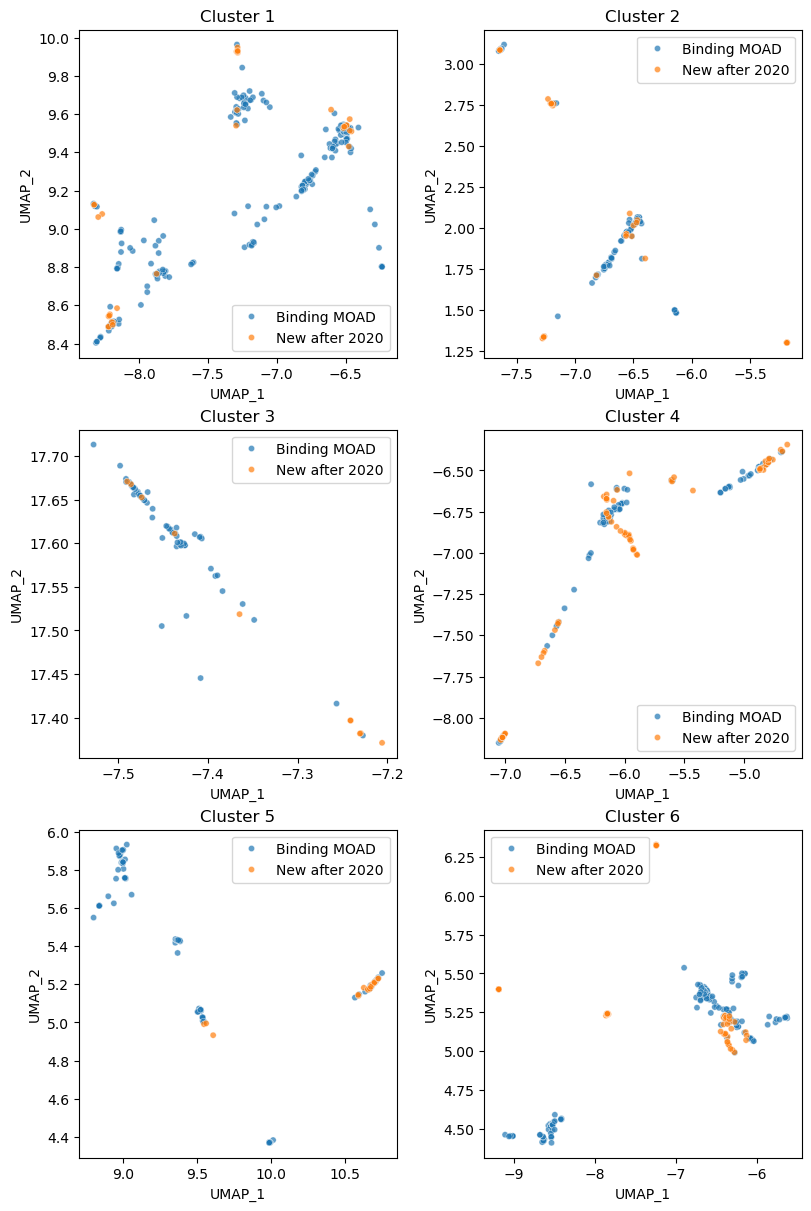

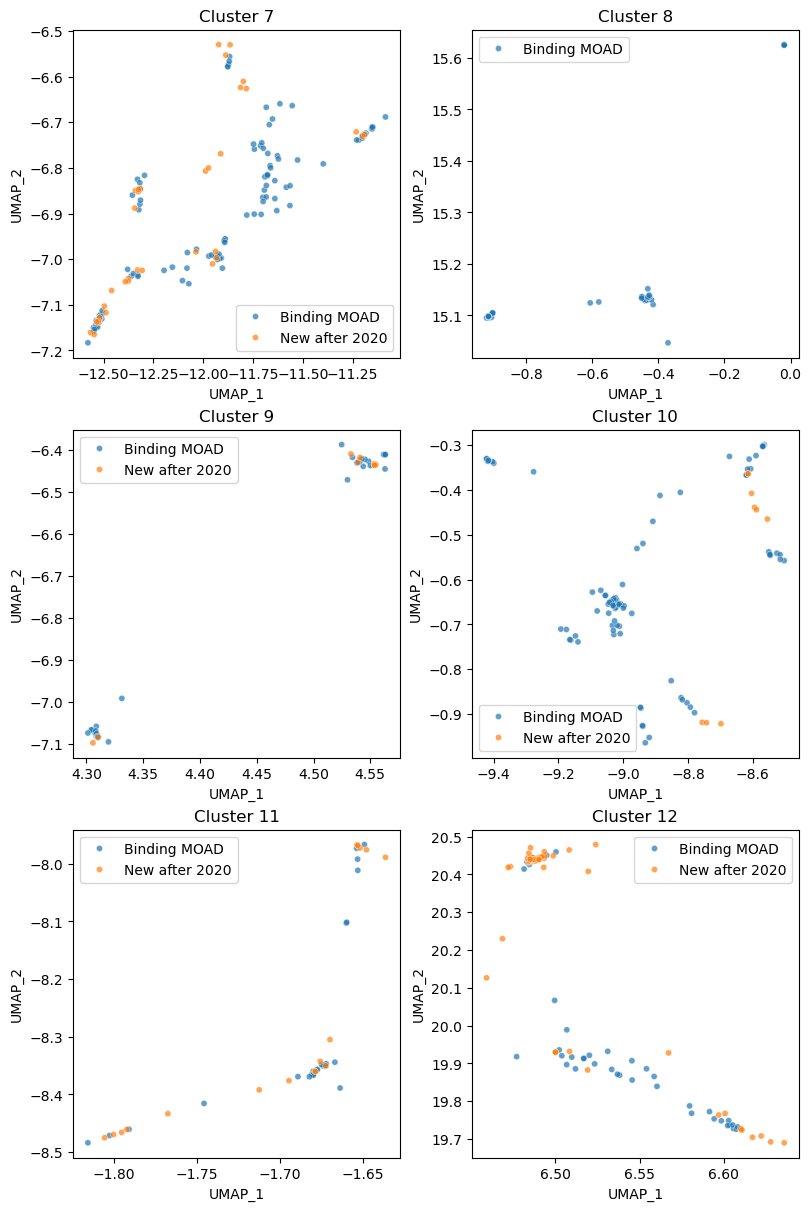

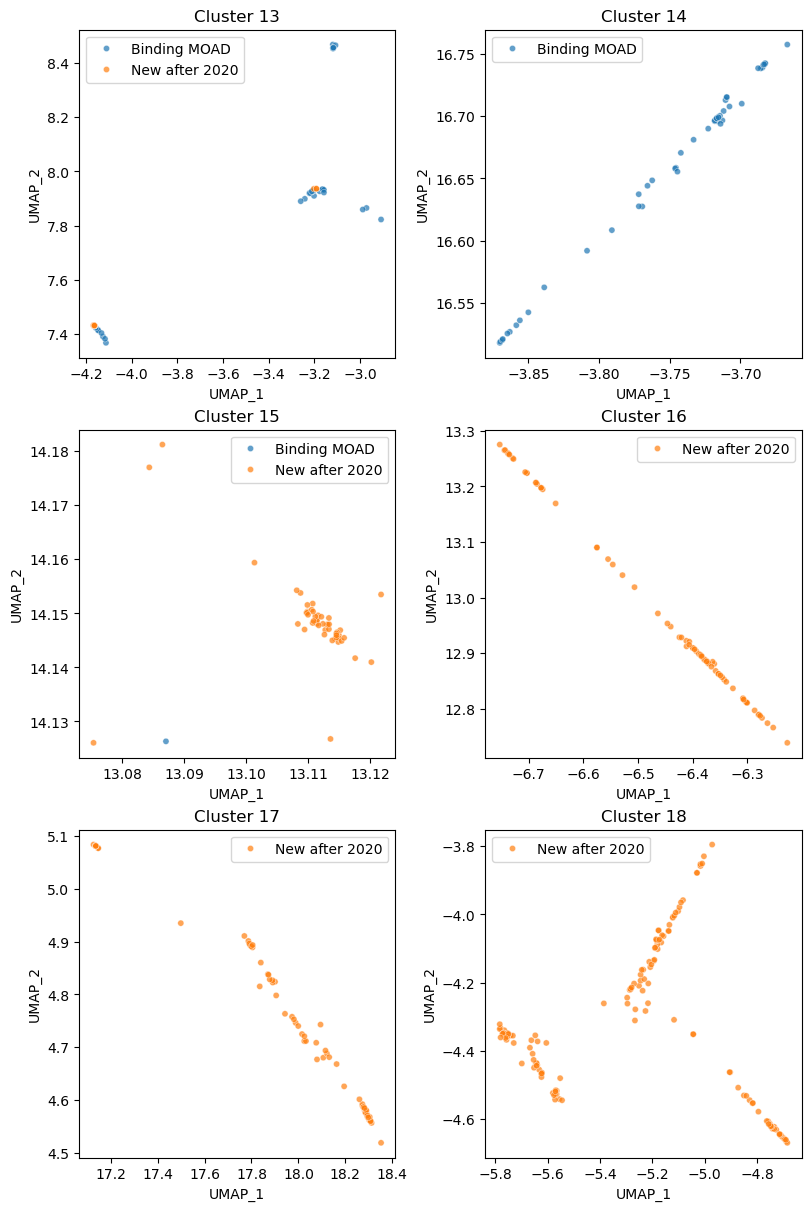

In [55]:
clusters = sorted([c for c in cluster_results['Cluster'].unique() if c > 0])
cluster_chunks = [clusters[i:i+6] for i in range(0, len(clusters), 6)]
custom_labels = {'BindingMOAD': 'Binding MOAD', 'New2020': 'New after 2020'}

for idx, chunk in enumerate(cluster_chunks):
    fig, axes = plt.subplots(3, 2, figsize=(8, 12), constrained_layout=True)

    for i, cluster_id in enumerate(chunk):
        ax = axes.flat[i]
        data = cluster_results[cluster_results['Cluster'] == cluster_id]

        sns.scatterplot(
            data=data,
            x='UMAP_1',
            y='UMAP_2',
            hue='Source',
            palette={'BindingMOAD': '#1f77b4', 'New2020': '#ff7f0e'},
            s=20,
            alpha=0.7,
            ax=ax
        )

        ax.set_title(f"Cluster {cluster_id}")
        handles, labels = ax.get_legend_handles_labels()
        new_labels = [custom_labels.get(label, label) for label in labels]
        ax.legend(handles=handles, labels=new_labels, frameon=True)

    # Save each figure
    fig.savefig(f'../images/clusters_by_source_{idx + 1:02d}.png', dpi=300, bbox_inches='tight')
    plt.show()


In [61]:
cluster_vs_source = pd.crosstab(cluster_results['Cluster'], cluster_results['Source'])

cluster_vs_source['Total'] = cluster_vs_source.sum(axis=1)

total_points = cluster_vs_source['Total'].sum()
cluster_vs_source['% of the total'] = cluster_vs_source['Total'] / total_points

cluster_vs_source['% BindingMOAD'] = cluster_vs_source['BindingMOAD'] / cluster_vs_source['Total']
cluster_vs_source['% New2020'] = cluster_vs_source['New2020'] / cluster_vs_source['Total']

cluster_vs_source_sorted = cluster_vs_source.sort_values('Total', ascending=False)

cluster_vs_source_sorted

Source,BindingMOAD,New2020,Total,% of the total,% BindingMOAD,% New2020
Cluster,,,,,,
0,7979,4013,11992,0.714788,0.665360,0.334640
-1,1636,1029,2665,0.158848,0.613884,0.386116
6,219,60,279,0.016630,0.784946,0.215054
1,235,35,270,0.016093,0.870370,0.129630
4,137,75,212,0.012636,0.646226,0.353774
7,132,35,167,0.009954,0.790419,0.209581
18,0,154,154,0.009179,0.000000,1.000000
2,102,40,142,0.008464,0.718310,0.281690
5,109,18,127,0.007570,0.858268,0.141732


In [16]:
cluster_vs_source = cluster_vs_source.reset_index()

print(f'Ligands from BM in clusters not 0 and -1: {cluster_vs_source[cluster_vs_source.Cluster > 0].BindingMOAD.sum()}')
print(f'Ligands from PDB in clusters not 0 and -1: {cluster_vs_source[cluster_vs_source.Cluster > 0].New2020.sum()}')

print(f'Ligands from BM for %BM > 80: {cluster_vs_source.sort_values(by="% BindingMOAD").BindingMOAD[-7:].sum()}')
print(f'Ligands from BM for %BM > 80: {cluster_vs_source.sort_values(by="% New2020").New2020[-4:].sum()}')



Ligands from BM in clusters not 0 and -1: 1359
Ligands from PDB in clusters not 0 and -1: 761
Ligands from BM for %BM > 80: 653
Ligands from BM for %BM > 80: 374


In [62]:
cluster_vs_source.sort_values(by="% New2020")

Source,BindingMOAD,New2020,Total,% of the total,% BindingMOAD,% New2020
Cluster,,,,,,
14,54,0,54,0.003219,1.000000,0.000000
8,53,0,53,0.003159,1.000000,0.000000
10,95,9,104,0.006199,0.913462,0.086538
1,235,35,270,0.016093,0.870370,0.129630
3,63,10,73,0.004351,0.863014,0.136986
5,109,18,127,0.007570,0.858268,0.141732
9,44,11,55,0.003278,0.800000,0.200000
7,132,35,167,0.009954,0.790419,0.209581
6,219,60,279,0.016630,0.784946,0.215054


In [ ]:
enriched_bm = enriched_bm.merge(df_all[['UniProt_ID', 'Template', 'Source']],
                                on=['UniProt_ID', 'Template'], how='left')
enriched_bm

In [ ]:
uniprot_counts = enriched_bm['UniProt_ID'].value_counts()
bins = [0, 2, 5, 10, 20, 50, 100, float('inf')]
# bins = [0, 2, 5, 10, 20, 30, 40, 50, float('inf')]

labels = [f"{bins[i]+1} - {bins[i+1]}" if bins[i+1] != float('inf') else f"> {bins[i]+1}" for i in range(len(bins)-1)]

binned = pd.cut(uniprot_counts, bins=bins, right=True, labels=labels)
hist_data = binned.value_counts().sort_index()

plt.figure(figsize=(5, 5))
hist_data.plot(kind='bar', color='skyblue', edgecolor='black', width=0.8, linewidth=1.2)

plt.xlabel('Number of complexes', fontsize=14)
plt.ylabel('Number of targets', fontsize=14)

plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')

plt.savefig('../images/templates_per_target.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
print(f'Unique uniprots 2020: {len(enriched_bm.UniProt_ID.unique())}')
print(f'Templates 2020: {len(enriched_bm)}\n')

In [ ]:
bm_confirmed = enriched_bm[enriched_bm.Source == 'BindingMOAD']
new_targets_2020 = new_pdb[~new_pdb.UniProt_ID.isin(bm_confirmed.UniProt_ID)]

print(f'Unique uniprots BM: {len((bm_confirmed.UniProt_ID.unique()))}')
print(f'Templates BM: {len((bm_confirmed))}\n')

print(f'Unique uniprots 2020: {len(new_pdb.UniProt_ID.unique())}')
print(f'New templates 2020: {len(enriched_bm[enriched_bm.Source == "New2020"])}\n')

print(f'New targets 2020: {len(new_targets_2020.UniProt_ID.unique())}')
print(f'New tempaltes for new targets: {len(new_targets_2020)}')
print(f'List: {new_targets_2020.UniProt_ID.unique()}')


In [ ]:
count_new_targets = new_targets_2020.groupby('UniProt_ID').size().reset_index(name='count').sort_values(by='count', ascending=False)
count_new_targets